In [3]:
import os
os.chdir('../')
%pwd

'/media/Ubuntu/meg/mlprojects/Semantic_Segmentation_for_self_driving_cars'

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob

2023-09-24 16:08:26.719784: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-24 16:08:27.380823: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
from dataclasses import dataclass 
from pathlib import Path

@dataclass(frozen=True)
class DataIngestionConfig:
    root_dir:Path

In [15]:
from src.constants import *
from src.utils.common import read_yaml,create_directories

In [16]:
class ConfigurationManager:
    def __init__(
            self,
            config_filepath= CONFIG_FILE_PATH,
            params_filepath= PARAMS_FILE_PATH):
        
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        
        create_directories([self.config.artifacts_root])

    def get_data_ingestion_config(self)-> DataIngestionConfig:
            config = self.config.data_ingestion
            params = self.params
            
            create_directories([config.root_dir])

            data_ingestion_config = DataIngestionConfig(
                root_dir= config.root_dir )

            return data_ingestion_config

In [17]:
class DataIngestion:
    def __init__(self, config : DataIngestionConfig):
        self.config=config

    def prepare_data(self):
        root_dir = self.config.root_dir
        imgs_list_1=[]
        masks_list_1=[]

        temp_a = []
        for dirpath, dirnames, filenames in os.walk(root_dir):
            temp_a.append(dirnames)
            data_dirs = sorted(temp_a[0])[:5]

        for folder in data_dirs:
            imgs_list_1.append(glob.glob(root_dir +'/' + folder+'/'+ folder+'/CameraRGB/*.png'))
            masks_list_1.append(glob.glob(root_dir +'/' + folder+'/'+ folder+'/CameraSeg/*.png'))


        # Transforming the list of lists of images and masks into one list for images and one for masks
        imgs_list = []
        masks_list = []

        for sublist in imgs_list_1:
            imgs_list.extend(sublist)
        for sublist in masks_list_1:
            masks_list.extend(sublist)

        return imgs_list,masks_list


        

In [18]:
try:
    config = ConfigurationManager()
    data_ingestion_config= config.get_data_ingestion_config()
    data_ingestion= DataIngestion(config = data_ingestion_config)
    imgs_list , masks_list = data_ingestion.prepare_data()
    print(len(imgs_list))

except Exception as e:
    raise e

[2023-09-24 16:08:53,682: INFO: common: yaml fileconfig.yamlloaded Successfully]
[2023-09-24 16:08:53,684: INFO: common: yaml fileparams.yamlloaded Successfully]
[2023-09-24 16:08:53,685: INFO: common: created directory at:artifacts]
[2023-09-24 16:08:53,685: INFO: common: created directory at:/media/Ubuntu/meg/mlprojects/Semantic_Segmentation_for_self_driving_cars/archive]
5000


In [19]:
imgs_list[:1]

['/media/Ubuntu/meg/mlprojects/Semantic_Segmentation_for_self_driving_cars/archive/dataA/dataA/CameraRGB/06_00_020.png']

In [20]:
image_filenames = tf.constant(imgs_list)
masks_filenames = tf.constant(masks_list)
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/media/Ubuntu/meg/mlprojects/Semantic_Segmentation_for_self_driving_cars/archive/dataA/dataA/CameraRGB/06_00_020.png', shape=(), dtype=string)
tf.Tensor(b'/media/Ubuntu/meg/mlprojects/Semantic_Segmentation_for_self_driving_cars/archive/dataA/dataA/CameraSeg/06_00_020.png', shape=(), dtype=string)


2023-09-24 16:10:06.210480: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-24 16:10:06.397513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-24 16:10:06.397684: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [21]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (192, 256), method='nearest')
    input_mask = tf.image.resize(mask, (192, 256), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [22]:
uniques = set()

for img, mask in image_ds.take(5000):
    uniques.update(np.unique(mask.numpy()))
    
print(uniques)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}


### Testing the dataset


In [24]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

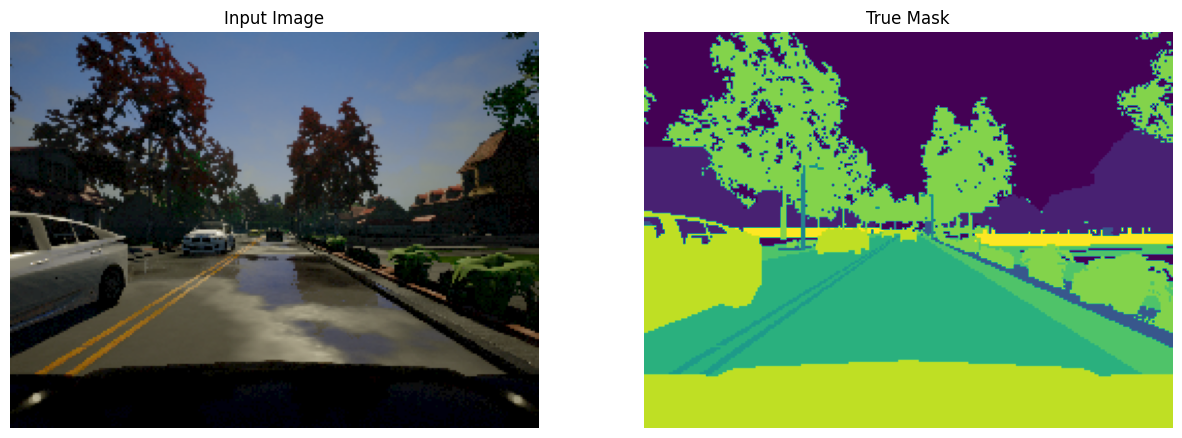

In [25]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])